In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.optim as optim

import random as rand

from sklearn import metrics

In [109]:
class Pokemon:
    def __init__(self, index, hp, inplay):
        self.index = index
        self.hp = hp
        self.inplay = inplay

    def __str__(self):
        return f"({pkms[self.index]}, HP: {self.hp}, InPlay: {'T' if self.inplay else 'F'})"

    def __repr__(self):
        return str(self)

class Decison:
    def __init__(self, mos, data):
        self.mos = mos
        self.data = data

    def __str__(self):
        return f"Attack using {moves[self.data]}" if self.mos else f"Switch to {pkms[self.data]}"

    def __repr__(self):
        return str(self)

class DataPoint:
    def __init__(self, team1, team2, decisions):
        self.team1, self.team2, self.decisions = [], [], []

        for pokemon in team1.split('\n'):
            index, hp, inplay = pokemon.split(',')
            self.team1.append(Pokemon(int(index), float(hp), inplay == 'True'))
        
        for pokemon in team2.split('\n'):
            index, hp, inplay = pokemon.split(',')
            self.team2.append(Pokemon(int(index), float(hp), inplay == 'True'))

        for decision in decisions.split('\n'):
            mos, data = decision.split(',')
            self.decisions.append(Decison(mos == 'True', int(data)))

class NeuralNetwork(nn.Module):
    def __init__(self, pkm, moves):
        super(NeuralNetwork, self).__init__()

    def bulk_predict(self, data):
        result = []
        count = 0
        for i, d in enumerate(data):
            try:
                result.append((i, self.predict(d)))
            except Exception as e:
                count += 1
                pass

        print(count)
        return result

    def train(self, data):
        optimizer = optim.SGD(self.parameters(), lr=0.5)

        epoch, batch_size = 500, 300
        indexes = [i for i in range(len(data))]

        for _ in tqdm(range(epoch)):
            for i in indexes:
                optimizer.zero_grad()

                # Get the targets from the data
                target = self.get_target(data[i])

                try:
                    output = [j for j in self.predict(data[i])]
                    loss = F.binary_cross_entropy(output, target)
                    loss.backward()
                    optimizer.step()

                    if loss < 0.1:
                        break

                except Exception as e:
                    pass

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def predict(self, data):
        team1, team2 = [int(i.index == j) for i in data.team1 for j in range(21)], [int(i.index == 0) for i in data.team2 for j in range(21)]
        team1hp, team2hp = [i.hp for i in data.team1], [i.hp for i in data.team2]
        team1cur, team2cur = [int(i.inplay) for i in data.team1], [int(i.inplay) for i in data.team2]
        features = torch.tensor(team1 + team1hp + team1cur + team2 + team2hp + team2cur)
        output = self.forward(torch.tensor(features))

        return output

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))

        return F.softmax(x, dim = 0)


# Class that inherits from the NeuralNetwork and 
class AttackOrSwitchNN(NeuralNetwork):
    def __init__(self, pkm, moves):
        super().__init__(pkm, moves)

        inputNum, outputNum = 21 * 6 + 6 + 6 + 21 * 6 + 6 + 6, 2
        self.pkm, self.moves = pkm, moves

        # Input layer represnts the pokemon and their hp and which pokemon is currently in play
        # The first hidden layer is meant to consider the hp of the pokemon of each player's active pokemon
        # The second hidden layer is meant to decide if there is a pokemon that can be switched in
        # The third hidden layer is meant to decide if there is a pokemon that can be switched in
        # This culminates into the output layer which ultimately decides if player 1 and player 2 should attack or switch
        layerSizes = [inputNum, (inputNum + outputNum + 10) // 2, outputNum]

        self.layers = nn.ModuleList()
        for i in range(len(layerSizes) - 1):
            self.layers.append(nn.Linear(layerSizes[i], layerSizes[i + 1]))

    def get_target(self, data):
        return torch.tensor([float(data.decisions[0].mos), float(data.decisions[1].mos)])

    def predict_print(self, data):
        output = self.predict(data)

        print('Player 1:', 'Attack' if output[0] > 0.5 else 'Switch')
        print('Player 2:', 'Attack' if output[1] > 0.5 else 'Switch')

    def calculate_error(self, data):
        correct, total = 0, len(data) * 2
        
        for d in data:
            try:
                output = self.predict(d)

                correct += int((output[0] > 0.5 and d.decisions[0].mos) or (output[0] < 0.5 and not d.decisions[0].mos))
                correct += int((output[1] > 0.5 and d.decisions[1].mos) or (output[1] < 0.5 and not d.decisions[1].mos))

            except Exception as e:
                total -= 1
        
        print(f'{total - correct} / {total}')
        return 1 - correct / total

In [22]:
print('Loading Pokemon Data ...')
import os
print(os.listdir())
with open('data/unique_pokemon.csv', 'r') as f:
    pkms = f.read().split(',')

print('Loading Move Data ...')
with open('data/unique_moves.csv', 'r') as f:
    moves = f.read().split(',')

print('Loading Training Data ...')
with open('data/datapoints.csv', 'r') as f:
    count = 0
    print('Splitting Data ...')
    data, datapoints = [], f.read().split('\n|-o-|\n')
    for datapoint in datapoints:
        if len(datapoint.split('\n|-s-|\n')) == 3:
            team1, team2, decisions = datapoint.split('\n|-s-|\n')
            data.append(DataPoint(team1, team2, decisions))

training_data_ratio = 0.6
training_data = data[:int(len(data) * training_data_ratio)]
testing_data = data[int(len(data) * training_data_ratio):]

Loading Pokemon Data ...
['learningModel', 'output_data', 'README.md', '.ipynb_checkpoints', 'gatherData', '.git', 'output.txt', 'ROC.ipynb', 'data', 'Makefile', 'models']
Loading Move Data ...
Loading Training Data ...
Splitting Data ...


In [370]:
net = AttackOrSwitchNN(pkms, moves)
net.train(training_data)
#net.load('models/attackSwitch.model')

In [371]:
print('Training Error Rate:', net.calculate_error(training_data))
print('Test Error Rate:', net.calculate_error(testing_data))

2235 / 2235
Training Error Rate: 1.0
1491 / 1491
Test Error Rate: 1.0


In [70]:
prediction_full = net.bulk_predict(testing_data)

/tmp/ipykernel_1430474/919550769.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.forward(torch.tensor(features))


18228


In [76]:
true_predictions = [int(j.mos) for i in prediction_full for j in data[i[0]].decisions]
predictions = [float(j) for i in prediction_full for j in i[1]]
error = sum([int(abs(i - j) > 0.5) for i, j in zip(true_predictions, predictions)]) / len(true_predictions)

In [81]:
print(predictions[4])

0.4946930706501007


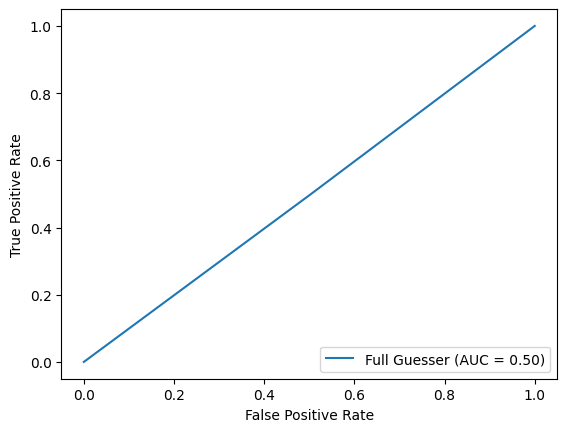

In [72]:
fpr, tpr, thresholds = metrics.roc_curve(true_predictions, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Full Guesser')
display.plot()

In [23]:
hp = [j.index for i in data for j in i.team1] + [j.index for i in data for j in i.team2]

Landorus


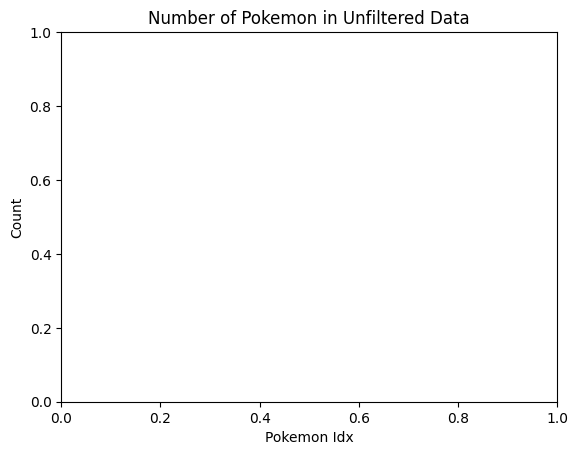

In [24]:
plt.title('Number of Pokemon in Unfiltered Data')
plt.xlabel('Pokemon Idx')
plt.ylabel('Count')
import numpy as np

test = [0] * (max(hp) + 1)

for i in hp:
    test[i] += 1
    
print(pkms[np.argmax(test)])

In [25]:
left = [i for i, ele in enumerate(test) if ele > 50000]
imap = {ele: i for i, ele in enumerate(left)}

print(left)

[80, 119, 147, 168, 191, 267, 339, 462, 470, 476, 485, 488, 506, 541, 579, 581, 622, 659, 686, 712, 715]


In [26]:
result_data = []
for i in data:
    skip = False
    
    for j in i.team1:
        if j.index not in left and j.hp != 0:
            skip = True
            
    for j in i.team2:
        if j.index not in left and j.hp != 0:
            skip = True
            
    if not skip:
        result_data.append(i)
        
print(len(result_data))

3726


In [27]:
training_data_ratio = 0.6
training_data = result_data[:int(len(result_data) * training_data_ratio)]
testing_data = result_data[int(len(result_data) * training_data_ratio):]

In [28]:
print(left)
for i in training_data:
    for j in i.team1:
        if (j.hp == 0):
            continue
        j.index = imap[j.index]
    
    for j in i.team2:
        if j.hp == 0:
            continue
        j.index = imap[j.index]

[80, 119, 147, 168, 191, 267, 339, 462, 470, 476, 485, 488, 506, 541, 579, 581, 622, 659, 686, 712, 715]


In [29]:
for i in testing_data:
    for j in i.team1:
        if (j.hp == 0):
            continue
        j.index = imap[j.index]
    
    for j in i.team2:
        if j.hp == 0:
            continue
        j.index = imap[j.index]

In [49]:
print(len(training_data))

2235


In [110]:
net = AttackOrSwitchNN(pkms, moves)
d = training_data[0]
output = net.predict(d)
print(output)
int((output[0] > 0.5 and d.decisions[0].mos) or (output[0] < 0.5 and not d.decisions[0].mos))
net.train(training_data)
print('Training Error Rate:', net.calculate_error(training_data))
print('Test Error Rate:', net.calculate_error(testing_data))

/tmp/ipykernel_1594541/56488419.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.forward(torch.tensor(features))


tensor([0.5051, 0.4949], grad_fn=<SoftmaxBackward0>)


100%|█████████████████████████████████████████████████████| 500/500 [02:35<00:00,  3.21it/s]


3099 / 4469
Training Error Rate: 0.6934437234280599
2105 / 2982
Test Error Rate: 0.7059020791415158


In [111]:
prediction_full = net.bulk_predict(testing_data)

0


/tmp/ipykernel_1594541/56488419.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.forward(torch.tensor(features))


In [112]:
true_predictions = [int(j.mos) for i in prediction_full for j in data[i[0]].decisions]
predictions = [float(j) for i in prediction_full for j in i[1]]
error = sum([int(abs(i - j) > 0.5) for i, j in zip(true_predictions, predictions)]) / len(true_predictions)

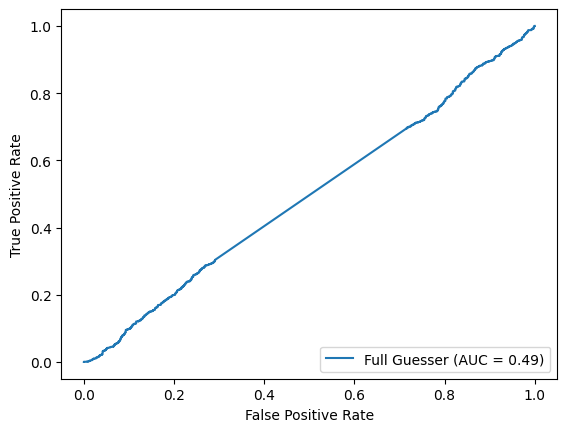

In [113]:
fpr, tpr, thresholds = metrics.roc_curve(true_predictions, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Full Guesser')
display.plot()